# Fall detector
## \[5ARB0\] Data Acquisition and Analysis - Technical Assignment

In [1]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

## Introduction
In this assignment you will use the previously learned data analysis methods and apply them to create a fall detector. After collecting and preprocessing sensor recording, you will extract a set of features which you will use for creating a fall detector.

This assignment is split into 4 parts. Parts 1-3 encompass the collection, preprocessing and feature extraction of sensor recordings. Finally, in part 4 you will create a fall detector.

### Learning goals
After this assignment you can
- collect data according to a protocol;
- load and merge datasets;
- preprocess data;
- extract features from data;
- apply analysis methods for creating a fall detector.

## Part 1: Data collection

Collect the data according to the data collection protocol provided on Canvas.

> (For iPhone) If you have issues accessing the (live) calibrated data of the _Sensor Logger_ app, you need to enable motion and compas calibration on your phone as explained [here](https://www.lifewire.com/how-to-calibrate-an-iphone-4172146). You will notice this once the live view and the export yield empty results.

## Part 2: Data cleaning and preprocessing
In this part you will be working on cleaning and preprocessing the data that you have gathered for further analysis.


---
---
### Exercise 2.1: Read, merge and select data
Load one of your individuals recordings in a Pandas DataFrame called `data`. You may want to have a look at the `pd.merge_asof` function to combine the recordings of the different sensors. Make sure that the `data` dataframe does not contain any `NaN`'s or empty fields as a result of different sampling frequencies. Any columns/recordings that you will not be using in your experiment should be removed from `data` (except for the `seconds_elapsed` column). Also remove duplicate colums. In the end your dataframe should have an indexing column, a column called `seconds_elapsed`, followed by the columns corresponding to the measurements.

In [2]:
#// BEGIN_TODO [5ARB0_FallDetector_2_1] Read, merge and select data

def readDataFromCSV(acc_CSV, grav_CSV, gyro_CSV):
    '''
    Reads the data from the CSV files and returns them
    :params: the 3 datasets to be read
    returns 3 datasets as a dataframe
    '''
    acc_df = pd.read_csv(acc_CSV)
    gyro_df = pd.read_csv(gyro_CSV)
    grav_df = pd.read_csv(grav_CSV)
    return acc_df, grav_df, gyro_df

def MergeDatasets(acc_df, grav_df, gyro_df):
    '''
    Merges the datasets given as params
    :params: the 3 datasets to be merged
    returns a dataframe
    '''
    tolerance = 0.1
    # combine acc and gyro
    df = pd.merge_asof(acc_df, gyro_df, on='seconds_elapsed', suffixes=['', '_gyro'], tolerance= tolerance, direction='nearest')
    # combine acc+gyro and grav
    df = pd.merge_asof(df, grav_df, on='seconds_elapsed', suffixes=['_acc', '_grav'], tolerance= tolerance, direction='nearest')

    #remove unused columns, nan and duplicates
    df = df.drop(columns=['time_acc', 'time_gyro', 'time_grav']).drop_duplicates().dropna()

    return df

#// END_TODO [5ARB0_FallDetector_2_1]

In [3]:
# Daniel's stand condition, trial 1
dnl_acc_CSV = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Accelerometer.csv"
dnl_grav_CSV = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Gravity.csv"
dnl_gyro_CSV = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Gyroscope.csv"

# read data
dnl_acc_df, dnl_gyro_df, dnl_grav_df = readDataFromCSV(dnl_acc_CSV, dnl_gyro_CSV, dnl_grav_CSV)
# merge data
data = MergeDatasets(dnl_acc_df, dnl_gyro_df, dnl_grav_df)

#show data
data

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
0,0.146083,0.000000,0.000000,0.000000,8.006465,5.622877,-0.670951,0.278034,-0.664458,0.136221
1,0.156124,-0.028530,0.103019,0.138830,7.946890,5.725518,-0.485553,0.171507,-0.626109,0.304399
2,0.166344,-0.240870,0.079999,-0.072005,7.867237,5.835296,-0.475711,0.055394,-0.515321,0.441818
3,0.176217,-0.523833,-0.059002,-0.245359,7.787525,5.936728,-0.529233,-0.025566,-0.367250,0.507864
4,0.186258,-0.646675,-0.103556,-0.354661,7.710637,6.028436,-0.611899,-0.084023,-0.139416,0.491885
...,...,...,...,...,...,...,...,...,...,...
2290,26.911646,-0.165359,0.083551,0.158941,8.845161,4.194827,-0.580462,0.036219,0.075767,-0.089615
2291,26.921677,-0.204567,0.105250,0.154618,8.843606,4.198024,-0.581053,0.036219,0.075767,-0.089615
2292,26.931735,-0.093494,0.095814,0.145486,8.843465,4.198252,-0.581532,0.036219,0.075767,-0.089615
2293,26.941769,0.034523,0.081493,0.077031,8.843783,4.197780,-0.580108,0.036219,0.075767,-0.089615


### End of exercise 2.1
---
---

In order to restrict our focus to fall detection, we would like to trim the recorded segment. In this way we can remove the movements corresponding to starting and stopping the sensor logger app. 

---
---
### Exercise 2.2: Trim data
Remove the first and last 5 seconds of the recordings for this purpose and save this trimmed data frame to `data_trimmed`. Make sure that your code works for a data frame containing an arbitrary number of columns.

In [3]:
#// BEGIN_TODO [5ARB0_FallDetector_2_2] Trim data

def trimDataset(data: pd.DataFrame, fromStart= 5, fromEnd=5):
    '''
    Removes 'fromStart' number of seconds from the beginning of the sample and removes 'fromEnd' number of seconds from the end of sample.
    :fromStart: the number of seconds to be removed from the beginning of the record
    :fromEnd: the number of seconds to be removed from the end of the record
    @returns the trimmed dataset
    '''
    
    # from the beginning
    data = data.drop(
        data[data['seconds_elapsed'] < fromStart].index
    )

    # from the end
    data = data.drop(
        data[data['seconds_elapsed'] > data['seconds_elapsed'].max() - fromEnd].index
    )

    # reset the index whilst removing old index column
    return data.reset_index(drop=True)

#// END_TODO [5ARB0_FallDetector_2_2]

In [39]:
data_trimmed = trimDataset(data)
data_trimmed

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
0,7.268935,-0.137248,0.698496,1.141784,1.777337,-8.923182,-3.659001,0.154463,1.039564,0.729439
1,7.278969,-0.238461,0.296979,1.085707,1.870167,-8.877235,-3.723917,0.154463,1.039564,0.729439
2,7.289002,-0.562388,-0.750215,1.297325,1.974771,-8.825411,-3.792463,0.154463,1.039564,0.729439
3,7.299035,-1.362981,-1.764613,1.720465,2.096213,-8.771613,-3.851634,0.154463,1.039564,0.729439
4,7.309070,-2.406208,-2.324449,2.089088,2.230479,-8.717321,-3.899184,0.154463,1.039564,0.729439
...,...,...,...,...,...,...,...,...,...,...
600,21.905820,-3.938864,-4.210360,-3.655980,8.512507,4.721923,-1.187882,-6.281327,1.412406,1.495098
601,21.915836,-2.959685,-3.344396,-3.447975,8.407792,4.770100,-1.650931,-5.839376,2.067277,1.587775
602,21.925852,-1.804575,-2.564031,-3.399087,8.286499,4.806302,-2.098524,-5.380380,2.150368,1.683649
603,21.935868,-0.643910,-1.900748,-3.655062,8.165960,4.833255,-2.475303,-4.877709,1.597629,1.731586


### End of exercise 2.2
---
---

---
---
### Exercise 2.3: Normalize recordings
For improved processing, the recordings should be normalized. Normalize the recordings by subtracting its mean and by then dividing by its standard deviation. Perform this normalization for each column individually. Save your normalized data in the the data frame `data_norm`.

In [4]:
#// BEGIN_TODO [5ARB0_FallDetector_2_3] Normalize recordings

# ===== =====> Replace this line by your code. <===== ===== #

def normaliseDataset(df: pd.DataFrame):
    # dataset[column] -= dataset[column].mean()
    # dataset[column] /= dataset[column].std()
    # normalized_df = (df[]-df.mean())/df.std()
    
    _, x = df.shape
    for i in range(1, x):
        df.iloc[:,i] -= df.iloc[:,i].mean()
        df.iloc[:,i] /= df.iloc[:,i].std()

    return df

#// END_TODO [5ARB0_FallDetector_2_3]

In [41]:
data_norm = normaliseDataset(data_trimmed) 
data_norm 
# ? normalize seconds as well? 
# No, seconds is not normalized as you will end up with negative seconds. 
# Seconds is basicaly a representative of each row and not a feature.

,seconds_elapsed,z_acc,y_acc,x_acc,z_gyro,y_gyro,x_gyro,z_grav,y_grav,x_grav
0,7.268935,-0.058938,0.431675,0.506540,0.795721,-0.207579,-0.380746,0.402246,0.732932,0.331668
1,7.278969,-0.080327,0.329339,0.484583,0.829152,-0.186270,-0.453115,0.402246,0.732932,0.331668
2,7.289002,-0.148784,0.062437,0.567440,0.866824,-0.162236,-0.529529,0.402246,0.732932,0.331668
3,7.299035,-0.317975,-0.196106,0.733114,0.910560,-0.137286,-0.595493,0.402246,0.732932,0.331668
4,7.309070,-0.538443,-0.338793,0.877443,0.958915,-0.112107,-0.648502,0.402246,0.732932,0.331668
...,...,...,...,...,...,...,...,...,...,...
600,21.905820,-0.862343,-0.819461,-1.371959,3.221310,6.120615,2.374047,-4.083097,1.032084,0.735996
601,21.915836,-0.655411,-0.598750,-1.290517,3.183598,6.142958,1.857841,-3.775084,1.557523,0.784937
602,21.925852,-0.411298,-0.399856,-1.271376,3.139916,6.159747,1.358867,-3.455193,1.624191,0.835566
603,21.935868,-0.166012,-0.230803,-1.371599,3.096505,6.172247,0.938835,-3.104863,1.180699,0.860881


### End of exercise 2.3
---
---

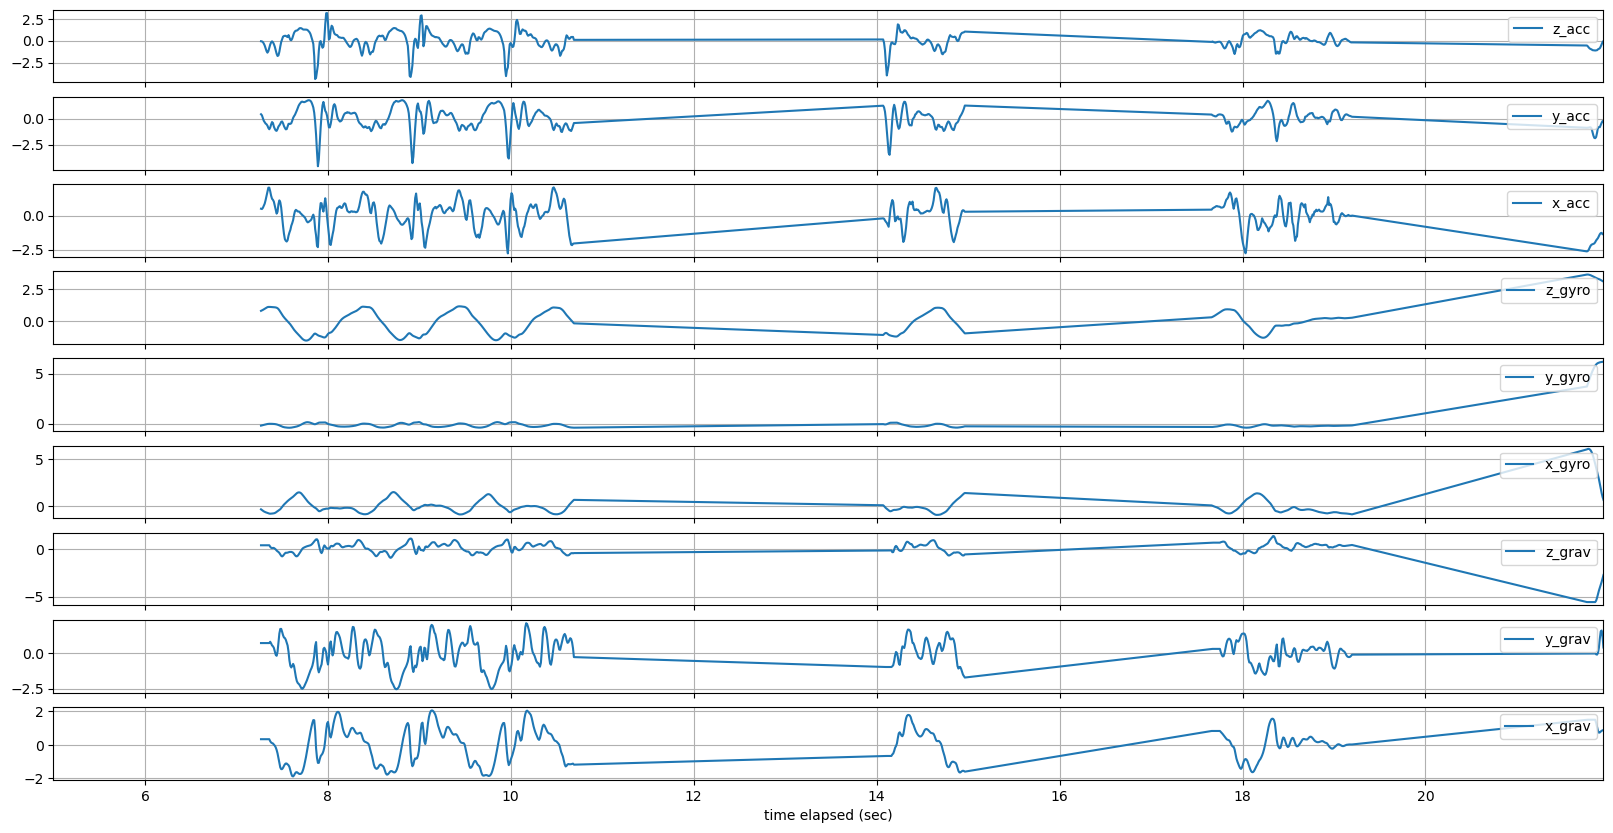

In [42]:
# plot recordings
ex2_plot_data(data_norm)

## Part 3: Feature extraction
The current data is not yet suited for detecting a fall. Based on the measurements at a specific point of time, it is difficult to determine whether someone has allen. Instead, it would be more appropriate to perform the fall detection over _segments_ of time. In this part you will extract features that will be used for detecting falls. But first all collected datasets will be processed.

---
---
### Exercise 3.1: Merge all datasets
Before starting the feature extraction, merge all the preprocessed datasets obtained in the protocol. You will need to load all recording, and again perform all preprocessing steps of Part 2 for the individual recordings. Make sure your code adheres to proper coding standards (make it look nice, don't copy part 2 15 times). Save your merged data in the the data frame `data_merged`.

In [5]:
#// BEGIN_TODO [5ARB0_FallDetector_3_1] Merge all datasets

# FUNCTION DEFINATIONS

def make_IR(trials: np.array): #NOT TRIED
    """
    Combines 5 trials of each condition to form an individual recording (IR) of 15 trials.

    :param trials: Array of trials where each element is dataframe.
    :returns: IR (Individual recording). type: dataframe
    """

    IR = pd.DataFrame()

    for i in range(len(trials)):
        IR = pd.concat([IR, trials[i, 0]], ignore_index=True) 
    
    return IR


def merge_IR(*all_IR: pd.DataFrame): #NOT TRIED
    """
    Combines all individual recordings (IR) to form merged dataframe consisting of 45 trials.

    :param *all_IR: tuple of all individual recordings (IR)
    :return: data_merged (type: dataframe)
    """

    data_merged = pd.DataFrame()

    for i in range(len(all_IR)):
        data_merged = pd.concat([data_merged, all_IR[i]], ignore_index=True)
    
    return data_merged


#### Import All Trials

In [6]:
# LOAD DATA

# All data is stored in matrix.
# Each row contains recording trials

# Column - Data
# 0 - accelerometer data
# 1 - gravity data
# 2 - gyroscope data

dnl_RawData_CSV = np.empty((15, 3), dtype='U1000') 
aryn_RawData_CSV = np.empty((15, 3), dtype='U1000') 
erk_RawData_CSV = np.empty((15, 3), dtype='U1000')

# Daniel Raw Data

# Kneel condition (I)

# trial 1
dnl_RawData_CSV[0, 0] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-31-35/Accelerometer.csv"
dnl_RawData_CSV[0, 1] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-31-35/Gravity.csv"
dnl_RawData_CSV[0, 2] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-31-35/Gyroscope.csv"

# trial 2
dnl_RawData_CSV[1, 0] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-32-24/Accelerometer.csv"
dnl_RawData_CSV[1, 1] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-32-24/Gravity.csv"
dnl_RawData_CSV[1, 2] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-32-24/Gyroscope.csv"

# trial 3
dnl_RawData_CSV[2, 0] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-33-25/Accelerometer.csv"
dnl_RawData_CSV[2, 1] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-33-25/Gravity.csv"
dnl_RawData_CSV[2, 2] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-33-25/Gyroscope.csv"

# trial 4
dnl_RawData_CSV[3, 0] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-34-13/Accelerometer.csv"
dnl_RawData_CSV[3, 1] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-34-13/Gravity.csv"
dnl_RawData_CSV[3, 2] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-34-13/Gyroscope.csv"

# trial 5
dnl_RawData_CSV[4, 0] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-35-00/Accelerometer.csv"
dnl_RawData_CSV[4, 1] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-35-00/Gravity.csv"
dnl_RawData_CSV[4, 2] = "./RawDataDaniel/Kneel_samples/2023-09-26_07-35-00/Gyroscope.csv"



# Sit conditon (II)

# trial 1
dnl_RawData_CSV[5, 0] = "./RawDataDaniel/Sit_samples/2023-09-26_07-22-27/Accelerometer.csv"
dnl_RawData_CSV[5, 1] = "./RawDataDaniel/Sit_samples/2023-09-26_07-22-27/Gravity.csv"
dnl_RawData_CSV[5, 2] = "./RawDataDaniel/Sit_samples/2023-09-26_07-22-27/Gyroscope.csv"

# trial 2
dnl_RawData_CSV[6, 0] = "./RawDataDaniel/Sit_samples/2023-09-26_07-23-33/Accelerometer.csv"
dnl_RawData_CSV[6, 1] = "./RawDataDaniel/Sit_samples/2023-09-26_07-23-33/Gravity.csv"
dnl_RawData_CSV[6, 2] = "./RawDataDaniel/Sit_samples/2023-09-26_07-23-33/Gyroscope.csv"

# trial 3
dnl_RawData_CSV[7, 0] = "./RawDataDaniel/Sit_samples/2023-09-26_07-24-29/Accelerometer.csv"
dnl_RawData_CSV[7, 1] = "./RawDataDaniel/Sit_samples/2023-09-26_07-24-29/Gravity.csv"
dnl_RawData_CSV[7, 2] = "./RawDataDaniel/Sit_samples/2023-09-26_07-24-29/Gyroscope.csv"

# trial 4
dnl_RawData_CSV[8, 0] = "./RawDataDaniel/Sit_samples/2023-09-26_07-25-27/Accelerometer.csv"
dnl_RawData_CSV[8, 1] = "./RawDataDaniel/Sit_samples/2023-09-26_07-25-27/Gravity.csv"
dnl_RawData_CSV[8, 2] = "./RawDataDaniel/Sit_samples/2023-09-26_07-25-27/Gyroscope.csv"

# trial 5
dnl_RawData_CSV[9, 0] = "./RawDataDaniel/Sit_samples/2023-09-26_07-26-26/Accelerometer.csv"
dnl_RawData_CSV[9, 1] = "./RawDataDaniel/Sit_samples/2023-09-26_07-26-26/Gravity.csv"
dnl_RawData_CSV[9, 2] = "./RawDataDaniel/Sit_samples/2023-09-26_07-26-26/Gyroscope.csv"



# Stand condition (III)

# trial 1
dnl_RawData_CSV[10, 0] = "./RawDataDaniel/Walk_samples/2023-09-26_07-16-17/Accelerometer.csv"
dnl_RawData_CSV[10, 1] = "./RawDataDaniel/Walk_samples/2023-09-26_07-16-17/Gravity.csv"
dnl_RawData_CSV[10, 2] = "./RawDataDaniel/Walk_samples/2023-09-26_07-16-17/Gyroscope.csv"
        
# trial 2
dnl_RawData_CSV[11, 0] = "./RawDataDaniel/Walk_samples/2023-09-26_07-18-21/Accelerometer.csv"
dnl_RawData_CSV[11, 1] = "./RawDataDaniel/Walk_samples/2023-09-26_07-18-21/Gravity.csv"
dnl_RawData_CSV[11, 2] = "./RawDataDaniel/Walk_samples/2023-09-26_07-18-21/Gyroscope.csv"

# trial 3
dnl_RawData_CSV[12, 0] = "./RawDataDaniel/Walk_samples/2023-09-26_07-18-59/Accelerometer.csv"
dnl_RawData_CSV[12, 1] = "./RawDataDaniel/Walk_samples/2023-09-26_07-18-59/Gravity.csv"
dnl_RawData_CSV[12, 2] = "./RawDataDaniel/Walk_samples/2023-09-26_07-18-59/Gyroscope.csv"

# trial 4
dnl_RawData_CSV[13, 0] = "./RawDataDaniel/Walk_samples/2023-09-26_07-19-35/Accelerometer.csv"
dnl_RawData_CSV[13, 1] = "./RawDataDaniel/Walk_samples/2023-09-26_07-19-35/Gravity.csv"
dnl_RawData_CSV[13, 2] = "./RawDataDaniel/Walk_samples/2023-09-26_07-19-35/Gyroscope.csv"

# trial 5
dnl_RawData_CSV[14, 0] = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Accelerometer.csv"
dnl_RawData_CSV[14, 1] = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Gravity.csv"
dnl_RawData_CSV[14, 2] = "./RawDataDaniel/Walk_samples/2023-09-26_07-15-41/Gyroscope.csv"


# Aryan Raw Data

# Kneel condition (I)

# trial 1
aryn_RawData_CSV[0, 0] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_1/Accelerometer.csv"
aryn_RawData_CSV[0, 1] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_1/Gravity.csv"
aryn_RawData_CSV[0, 2] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_1/Gyroscope.csv"

# trial 2
aryn_RawData_CSV[1, 0] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_2/Accelerometer.csv"
aryn_RawData_CSV[1, 1] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_2/Gravity.csv"
aryn_RawData_CSV[1, 2] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_2/Gyroscope.csv"

# trial 3
aryn_RawData_CSV[2, 0] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_3/Accelerometer.csv"
aryn_RawData_CSV[2, 1] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_3/Gravity.csv"
aryn_RawData_CSV[2, 2] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_3/Gyroscope.csv"

# trial 4
aryn_RawData_CSV[3, 0] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_4/Accelerometer.csv"
aryn_RawData_CSV[3, 1] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_4/Gravity.csv"
aryn_RawData_CSV[3, 2] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_4/Gyroscope.csv"

# trial 5
aryn_RawData_CSV[4, 0] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_5/Accelerometer.csv"
aryn_RawData_CSV[4, 1] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_5/Gravity.csv"
aryn_RawData_CSV[4, 2] = "./RawData_Aryan/I-Fall_(Kneel)_Samples/Scenario_I,_Trial_5/Gyroscope.csv"


# Sit conditon (II)

# trial 1
aryn_RawData_CSV[5, 0] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_1/Accelerometer.csv"
aryn_RawData_CSV[5, 1] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_1/Gravity.csv"
aryn_RawData_CSV[5, 2] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_1/Gyroscope.csv"

# trial 2
aryn_RawData_CSV[6, 0] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_2/Accelerometer.csv"
aryn_RawData_CSV[6, 1] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_2/Gravity.csv"
aryn_RawData_CSV[6, 2] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_2/Gyroscope.csv"

# trial 3
aryn_RawData_CSV[7, 0] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_3/Accelerometer.csv"
aryn_RawData_CSV[7, 1] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_3/Gravity.csv"
aryn_RawData_CSV[7, 2] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_3/Gyroscope.csv"

# trial 4
aryn_RawData_CSV[8, 0] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_4/Accelerometer.csv"
aryn_RawData_CSV[8, 1] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_4/Gravity.csv"
aryn_RawData_CSV[8, 2] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_4/Gyroscope.csv"

# trial 5
aryn_RawData_CSV[9, 0] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_5/Accelerometer.csv"
aryn_RawData_CSV[9, 1] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_5/Gravity.csv"
aryn_RawData_CSV[9, 2] = "./RawData_Aryan/II-Sit_Samples/Scenario_II,_Trial_5/Gyroscope.csv"



# Stand condition (III)

# trial 1
aryn_RawData_CSV[10, 0] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_1/Accelerometer.csv"
aryn_RawData_CSV[10, 1] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_1/Gravity.csv"
aryn_RawData_CSV[10, 2] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_1/Gyroscope.csv"

# trial 2
aryn_RawData_CSV[11, 0] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_2/Accelerometer.csv"
aryn_RawData_CSV[11, 1] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_2/Gravity.csv"
aryn_RawData_CSV[11, 2] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_2/Gyroscope.csv"

# trial 3
aryn_RawData_CSV[12, 0] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_3/Accelerometer.csv"
aryn_RawData_CSV[12, 1] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_3/Gravity.csv"
aryn_RawData_CSV[12, 2] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_3/Gyroscope.csv"

# trial 4
aryn_RawData_CSV[13, 0] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_4/Accelerometer.csv"
aryn_RawData_CSV[13, 1] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_4/Gravity.csv"
aryn_RawData_CSV[13, 2] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_4/Gyroscope.csv"

# trial 5
aryn_RawData_CSV[14, 0] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_5/Accelerometer.csv"
aryn_RawData_CSV[14, 1] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_5/Gravity.csv"
aryn_RawData_CSV[14, 2] = "./RawData_Aryan/III-Stand_Samples/Scenario_III,_Trial_5/Gyroscope.csv"



# Erik Raw Data

# trial 1
erk_RawData_CSV[0,0] = "./RawDataErik/2023-09-26_07-12-26/Accelerometer.csv"
erk_RawData_CSV[0,1] = "./RawDataErik/2023-09-26_07-12-26/Gravity.csv"
erk_RawData_CSV[0,2] = "./RawDataErik/2023-09-26_07-12-26/Gyroscope.csv"

# trial 2
erk_RawData_CSV[1,0] = "./RawDataErik/2023-09-26_07-14-21/Accelerometer.csv"
erk_RawData_CSV[1,1] = "./RawDataErik/2023-09-26_07-14-21/Gravity.csv"
erk_RawData_CSV[1,2] = "./RawDataErik/2023-09-26_07-14-21/Gyroscope.csv"

# trial 3
erk_RawData_CSV[2,0] = "./RawDataErik/2023-09-26_07-14-51/Accelerometer.csv"
erk_RawData_CSV[2,1] = "./RawDataErik/2023-09-26_07-14-51/Gravity.csv"
erk_RawData_CSV[2,2] = "./RawDataErik/2023-09-26_07-14-51/Gyroscope.csv"

# trial 4
erk_RawData_CSV[3,0] = "./RawDataErik/2023-09-26_07-16-05/Accelerometer.csv"
erk_RawData_CSV[3,1] = "./RawDataErik/2023-09-26_07-16-05/Gravity.csv"
erk_RawData_CSV[3,2] = "./RawDataErik/2023-09-26_07-16-05/Gyroscope.csv"

# trial 5
erk_RawData_CSV[4,0] = "./RawDataErik/2023-09-26_07-16-41/Accelerometer.csv"
erk_RawData_CSV[4,1] = "./RawDataErik/2023-09-26_07-16-41/Gravity.csv"
erk_RawData_CSV[4,2] = "./RawDataErik/2023-09-26_07-16-41/Gyroscope.csv"

# trial 6
erk_RawData_CSV[5,0] = "./RawDataErik/2023-09-26_07-22-46/Accelerometer.csv"
erk_RawData_CSV[5,1] = "./RawDataErik/2023-09-26_07-22-46/Gravity.csv"
erk_RawData_CSV[5,2] = "./RawDataErik/2023-09-26_07-22-46/Gyroscope.csv"

# trial 7
erk_RawData_CSV[6,0] = "./RawDataErik/2023-09-26_07-23-56/Accelerometer.csv"
erk_RawData_CSV[6,1] = "./RawDataErik/2023-09-26_07-23-56/Gravity.csv"
erk_RawData_CSV[6,2] = "./RawDataErik/2023-09-26_07-23-56/Gyroscope.csv"

# trial 8
erk_RawData_CSV[7,0] = "./RawDataErik/2023-09-26_07-24-49/Accelerometer.csv"
erk_RawData_CSV[7,1] = "./RawDataErik/2023-09-26_07-24-49/Gravity.csv"
erk_RawData_CSV[7,2] = "./RawDataErik/2023-09-26_07-24-49/Gyroscope.csv"

# trial 9
erk_RawData_CSV[8,0] = "./RawDataErik/2023-09-26_07-25-44/Accelerometer.csv"
erk_RawData_CSV[8,1] = "./RawDataErik/2023-09-26_07-25-44/Gravity.csv"
erk_RawData_CSV[8,2] = "./RawDataErik/2023-09-26_07-25-44/Gyroscope.csv"

# trial 10
erk_RawData_CSV[9,0] = "./RawDataErik/2023-09-26_07-26-51/Accelerometer.csv"
erk_RawData_CSV[9,1] = "./RawDataErik/2023-09-26_07-26-51/Gravity.csv"
erk_RawData_CSV[9,2] = "./RawDataErik/2023-09-26_07-26-51/Gyroscope.csv"

# trial 11
erk_RawData_CSV[10,0] = "./RawDataErik/2023-09-26_07-32-49/Accelerometer.csv"
erk_RawData_CSV[10,1] = "./RawDataErik/2023-09-26_07-32-49/Gravity.csv"
erk_RawData_CSV[10,2] = "./RawDataErik/2023-09-26_07-32-49/Gyroscope.csv"

# trial 12
erk_RawData_CSV[11,0] = "./RawDataErik/2023-09-26_07-33-53/Accelerometer.csv"
erk_RawData_CSV[11,1] = "./RawDataErik/2023-09-26_07-33-53/Gravity.csv"
erk_RawData_CSV[11,2] = "./RawDataErik/2023-09-26_07-33-53/Gyroscope.csv"

# trial 13
erk_RawData_CSV[12,0] = "./RawDataErik/2023-09-26_07-34-36/Accelerometer.csv"
erk_RawData_CSV[12,1] = "./RawDataErik/2023-09-26_07-34-36/Gravity.csv"
erk_RawData_CSV[12,2] = "./RawDataErik/2023-09-26_07-34-36/Gyroscope.csv"

# trial 14
erk_RawData_CSV[13,0] = "./RawDataErik/2023-09-26_07-35-24/Accelerometer.csv"
erk_RawData_CSV[13,1] = "./RawDataErik/2023-09-26_07-35-24/Gravity.csv"
erk_RawData_CSV[13,2] = "./RawDataErik/2023-09-26_07-35-24/Gyroscope.csv"

# trial 15
erk_RawData_CSV[14,0] = "./RawDataErik/2023-09-26_07-36-17/Accelerometer.csv"
erk_RawData_CSV[14,1] = "./RawDataErik/2023-09-26_07-36-17/Gravity.csv"
erk_RawData_CSV[14,2] = "./RawDataErik/2023-09-26_07-36-17/Gyroscope.csv"



# CONVERT CSVs TO DATAFRAME

dnl_RawData_df = np.empty((15,3), dtype=object)
aryn_RawData_df = np.empty((15,3), dtype=object)
erk_RawData_df = np.empty((15,3), dtype=object)

for i in range(15):
    dnl_RawData_df[i, 0], dnl_RawData_df[i, 1], dnl_RawData_df[i, 2] = readDataFromCSV(dnl_RawData_CSV[i, 0], dnl_RawData_CSV[i, 1], dnl_RawData_CSV[i, 2])
    aryn_RawData_df[i, 0], aryn_RawData_df[i, 1], aryn_RawData_df[i, 2] = readDataFromCSV(aryn_RawData_CSV[i, 0], aryn_RawData_CSV[i, 1], aryn_RawData_CSV[i, 2])
    erk_RawData_df[i, 0], erk_RawData_df[i, 1], erk_RawData_df[i, 2] = readDataFromCSV(erk_RawData_CSV[i, 0], erk_RawData_CSV[i, 1], erk_RawData_CSV[i, 2])
    

# MERGE SENSOR DATA OF EACH TRIAL

dnl_Data = np.empty((15,1), dtype=object)
aryn_Data = np.empty((15,1), dtype=object)
erk_Data = np.empty((15,1), dtype=object)

for i in range(15):
    dnl_Data[i, 0] = MergeDatasets(dnl_RawData_df[i, 0], dnl_RawData_df[i, 1], dnl_RawData_df[i, 2])
    aryn_Data[i, 0] = MergeDatasets(aryn_RawData_df[i, 0], aryn_RawData_df[i, 1], aryn_RawData_df[i, 2])
    erk_Data[i, 0] = MergeDatasets(erk_RawData_df[i, 0], erk_RawData_df[i, 1], erk_RawData_df[i, 2])


#### Data Preprocessing

In [7]:
# Create Empty Matrix for trimming and normalizing

dnl_Data_trimmed = np.empty((15,1), dtype=object)
aryn_Data_trimmed = np.empty((15,1), dtype=object)
erk_Data_trimmed = np.empty((15,1), dtype=object)

dnl_Data_norm = np.empty((15,1), dtype=object)
aryn_Data_norm = np.empty((15,1), dtype=object)
erk_Data_norm = np.empty((15,1), dtype=object)

for i in range(15):
    
    # Trimming
    dnl_Data_trimmed[i, 0] = trimDataset(dnl_Data[i, 0])
    aryn_Data_trimmed[i, 0] = trimDataset(aryn_Data[i, 0])
    erk_Data_trimmed[i, 0] = trimDataset(erk_Data[i, 0])

    # Normalizing
    dnl_Data_norm[i, 0] = normaliseDataset(dnl_Data_trimmed[i, 0])
    aryn_Data_norm[i, 0] = normaliseDataset(aryn_Data_trimmed[i, 0])
    erk_Data_norm[i, 0] = normaliseDataset(erk_Data_trimmed[i, 0])


#### Data Merge

In [8]:
# Merge trials of each individual

dnl_IR = make_IR(dnl_Data_norm)
aryn_IR = make_IR(aryn_Data_norm)
erk_IR = make_IR(erk_Data_norm)


# Merge all individual recordings

data_merged = merge_IR(aryn_IR, dnl_IR, erk_IR)

#// END_TODO [5ARB0_FallDetector_3_1]

### End of exercise 3.1
---
---

---
---
### Exercise 3.2: Convert data frame to matrix
In order to extract features from the recording, first convert the dataframe to a Numpy matrix called `mat`. This matrix should have dimensions (_nr of time points_, _nr or different recordings_). Make sure that you remove the _seconds_elapsed_ column, as this does not yield any useful information for the fall detector.

In [9]:
#// BEGIN_TODO [5ARB0_FallDetector_3_2] Convert data frame to matrix

# Remove seconds_elapsed column
data_merged = data_merged.drop("seconds_elapsed", axis=1)

# dataframe to matrix
mat = data_merged.to_numpy()

#// END_TODO [5ARB0_FallDetector_3_2]

### End of exercise 3.2
---
---

Now that the data frame has been converted to a matrix, it can be split into different overlapping segments, of which we can extract features. As a starting point we will specify features as the mean value of a segment, its standard deviation, its minimum and its maximum.

---
---
### Exercise 3.3: Processing segments
Create a function `Y = process_segment(mat, fun, L, K)` that processes time segments of the matrix `mat`. The argument `fun` specifies the operation to be performed on the segment and its value comes from the set `["mean", "std", "minimum", "maximum"]`. `L` specifies the segment length and `K` specifies the number of samples overlap between segments. The function should return a matrix `Y` with dimensions (_nr of segments_, _nr of different recordings_)

In [10]:
#// BEGIN_TODO [5ARB0_FallDetector_3_3] Process segments

def process_segment(mat, fun, L, K): #NOT TRIED

    nr_rows, nr_cols = mat.shape

    # Calculate no. of segments
    nr_seg = int((nr_rows - L) / K) + 1

    # Initialize Y matrix
    Y = np.zeros((nr_seg, nr_cols))

    # Fill segments with values after applying operations defined by fun

    for i in range(nr_seg):
        # Calculate the start and end index of each segment
        seg_start = i * K
        seg_end = seg_start + L

        # Insure seg_end does not get greater than number of mat rows
        
        if seg_end > nr_rows:
            seg_end = nr_rows 
        
        # Get values from mat into segment as per its indices
        segment = mat[seg_start:seg_end, :]

        # Apply the fun function to segment
        if fun == "mean":
            segment_final = np.mean(segment, axis=0)
        elif fun == "std":
            segment_final = np.std(segment, axis=0) 
        elif fun == "minimum":
            segment_final = np.min(segment, axis=0) 
        elif fun == "maximum":
            segment_final = np.max(segment, axis=0)

        # Append final segment to Y
        Y[i, :] = segment_final

    return Y 


#// END_TODO [5ARB0_FallDetector_3_3]

In [11]:
Y_mean = process_segment(mat, "mean", 100, 50)
Y_std = process_segment(mat, "std", 100, 50)
Y_minimum = process_segment(mat, "minimum", 100, 50)
Y_maximum = process_segment(mat, "maximum", 100, 50)

### End of exercise 3.3
---
---

---
---
### Exercise 3.4: Concatenate features
Now that you have computed some features of the recordings, it becomes necessary to combine them into a single matrix. Create the matrix `features` which concatenates the above results along the appropriate axis.

In [12]:
#// BEGIN_TODO [5ARB0_FallDetector_3_4] Concatenate features

features = np.hstack((Y_mean, Y_std, Y_minimum, Y_maximum))

#// END_TODO [5ARB0_FallDetector_3_4]

### End of exercise 3.4
---
---

## Part 4: Fall detector
In this part of the assignment we will use the previously implemented data analysis methods to create a simple fall detector. You will be given more freedom to experiment with the different techniques used.

During this part you can make use of the `sklearn` (Scikit learn) package. This package offers some benefits over the handwritten clustering functions. These algorithms are numerically stable and better optimized to run on large data sets.

In [ ]:
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

---
---
### Exercise 4.1: Fall detector
In this assignment you will create your own fall detector, using the previously recorded data and learned data analysis methods. You are free to add more features to the dataset if you want. Possible steps include: 1) feature extraction, 2) data compression and 3) clustering.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_4_1] Fall detector

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_4_1]

### End of exercise 4.1
---
---

---
---
### Exercise 4.2: Fall classification
Use your fall detector to classify when someone has fallen. Plot your fall classification over time.

In [ ]:
#// BEGIN_TODO [5ARB0_FallDetector_4_2] Classify falls

# ===== =====> Replace this line by your code. <===== ===== #

#// END_TODO [5ARB0_FallDetector_4_2]

### End of exercise 4.2
---
---

---
---
### Exercise 4.3: Classification improvements
You might have noticed that it is not easy to create a fall detector. How do you think that you could improve the performance? Please carefully describe the current flaws and ways to deal with them, together with a list of next steps that you would take. Please elaborate on your answer.

### End of exercise 4.3
---
---

>   Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.